<h1> Transaction Fraud Detection (Machine Learning for Classification) </h1>
<br> 
<br> 

**This project utilizes machine learning algorithms for classification, particularly for transaction fraud detection. The dataset presented here consists of thousands of transaction records, in fact more than 6 million transactions, and key information about each transaction, including the sender's and recipient's account balances before and after the transaction, the amount of money transferred, and whether the transaction was in fact fraudulent or not. The aim of this project is to build a machine learning classification model that can accurately detect transaction fraud. Further, it focuses on both prediction efficiency and model interpretability, and tries to leverage both. This project was originally completed as per required for the final project of my course, 'Supervised Machine Learning: Classification', offered online by IBM. Overall, it displays a wide variety of data analysis tasks, classification algorithms, and model interpretation techniques.**

<br>

**The dataset being used here was taken from Kaggle.com, a popular website for finding and publishing datasets. You can quickly access it by clicking [here](https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset). It's a huge dataset that presents, as mentioned, thousands and thousands of monetary transactions and whether or not they were deemed fraud by the relevant authority, which will be utilized as material for developing and training the classification models.** <br> 
<br> 

**You can view each coloumn and its description in the table below:** <br><br>  

| **Variable**      | **Description**                                                                                         |
| :-----------------| :------------------------------------------------------------------------------------------------------ |
| **step**          | Represents a unit of time where 1 step = 1 hour                                                         |
| **type**          | Type of online transaction (Transfer, Payment, Debit, Cash-in, Cash-out)                                |
| **amount**        | The amount of money in a transaction                                                                    |
| **nameOrig**      | Name of the sender                                                                                      |
| **oldbalanceOrg** | The sender's balance before the transaction                                                             |
| **newbalanceOrig**| The sender's balance after the transaction                                                              |
| **nameDest**      | Name of the recipient                                                                                   |
| **oldbalanceDest**| The recipient's balance before the transaction                                                          |
| **newbalanceDest**| The recipient's balance after the transaction                                                           |
| **isFraud**       | Specifies if a transaction is fraud (1) or not fraud (0)                                                |
| **isFlaggedFraud**     | Indicates if a transaction was flagged as fraud (1) or not (0)                                     |

<br>
<br>


**As stated, the task here is to develop a classification model that can accurately detect transaction fraud. The data is first prepared, statistically analyzed, and preprocessed, before being used to train and test different classifiers. Note however, given that fraudulent cases, as we will see, make up less than 1% of all transactions, thus resulting in an extremely skewed or imbalanced dataset, different techniques are applied to deal with this problem first before developing the classifiers. Particularly, oversampling techniques were used to try and generate more data points for the minority class (fraud), by which way to balance the classes in the dataset to ensure that the classifiers are not biased during learning and can indeed predict transaction fraud reliably. Along the way, different classifiers are trained, tested and their parameters tuned to try to identify the best one for the data. Also, a subset of data was reserved for testing or out-of-sample evaluation to estimate how each classifier is likely to perform in the real world with novel datasets, unseen during the model training. Finally, after selecting the best classifier, model interpretation techniques are applied, such as permutation feature importance and partial dependence plots, in order to better understand how the final classifier was making its predictions, or, that is, based on what factors it was classifying one transaction as fraudulent and another as not. The most impactful features are identified and analyzed in more detail using a partial dependency plot, which illustrates through visualization the nature and direction of the relationship between that given feature and the likelihood of fraud as discerned by the model.** <br>

<br>

**Overall, the project is broken down into five parts: <br>
&emsp; 1) Reading and Inspecting the Data <br>
&emsp; 2) Exploratory Data Analysis <br>
&emsp; 3) Data Preprocessing <br>
&emsp; 4) Model Development, Tuning, and Evaluation <br>
&emsp; 5) Model Interpretation** <br>

<br>
<br>


**Installing and Importing Python Modules**

In [ ]:
#If you're using the executable notebook version, please run this cell first 
#to install the necessary Python libraries for the task 
!pip install numpy 
!pip install pandas 
!pip install matplotlib 
!pip install seaborn 
!pip install scikit-learn
!pip install imbalanced-learn

In [2]:
#Importing the modules for use 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.kernel_approximation import Nystroem

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

**Defining functions for model evaluation and interpretation**

In [3]:
#Defining functions to compute and report error scores
def error_scores(ytest, ypred, classes):
    error_metrics = {
        'Accuracy': accuracy_score(ytest, ypred),
        'Precision': precision_score(ytest, ypred, average=None),
        'Recall': recall_score(ytest, ypred, average=None),
        'F5': fbeta_score(ytest, ypred, beta=5, average=None) }

    return pd.DataFrame(error_metrics, index=classes).apply(lambda x:round(x,2)).T

def error_scores_dict(ytest, ypred, strategy):
    #create empty dict for storing results 
    error_dict = {}
    
    #specify type of result 
    error_dict['Strategy'] = strategy
    
    #Get accuracy score
    error_dict['Accuracy'] = round(accuracy_score(ytest, ypred),2)
    
    #Get Precision, recall, F-beta scores
    precision, recall, f_beta, _ = precision_recall_fscore_support(ytest, ypred, beta=5, average='binary')
    #store results
    error_dict['Precision'], error_dict['Recall'], error_dict['F5'] = round(recall,2), round(precision,2), round(f_beta,2) 
    
    return error_dict


#Defining a function to plot out confusion matrix
def plot_cm(ytest, ypred, classes):
    cm = confusion_matrix(ytest, ypred)
    fig,ax = plt.subplots()
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20, "weight": "bold"})
    labels = classes
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Prediction', fontsize=15)
    ax.set_ylabel('Actual', fontsize=15)
    plt.show()

    
#Defining a function to plot the ROC curve
def plot_ROC_curve(model, xtest, ytest):
    #Get model's predicted probabilities
    y_prob = model.predict_proba(xtest)
    y_pred = model.predict(xtest)
    #Get false positive and true positive rates
    false_pos_rate, true_pos_rate, thresholds = roc_curve(ytest, y_prob[:,1])
    #Get best auc score 
    auc_best = roc_auc_score(ytest, y_pred, average=None)

    #Plot the ROC curve
    fig, ax = plt.subplots()
    ax.plot(false_pos_rate, true_pos_rate, linewidth=2.5)
    plt.fill_between(false_pos_rate, true_pos_rate, alpha=0.1)
    
    #Plot the diagonal chance line 
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3) 
    plt.annotate('AUC=0.5', xy=(0.5, 0.5), xytext=(0.6, 0.3), 
                 arrowprops=dict(facecolor='black', headwidth=8, width=2.5, shrink=0.05))
    
    #Plot the best auc score
    ax.plot(auc_best, marker='o', color='r')
    plt.annotate(f'AUC={round(auc_best,2)}', xy=(0,auc_best), xytext=(0.1,0.8), 
                 arrowprops=dict(facecolor='gray', headwidth=7, width=2, shrink=0.15))
    
    #Set title and labels 
    ax.set(title='ROC curve',
           xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    
    #add grid 
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    
#Defining a function to plot ROC curve for multiple models 
def plot_ROC_curve_multiple(xtest, xtest_svc, ytest, estimators):
    #Get ROC curve for each model
    LR_fpr, LR_tpr, thresold = roc_curve(ytest, estimators[0].predict(xtest))
    KNN_fpr, KNN_tpr, threshold = roc_curve(ytest, estimators[1].predict(xtest))
    SVC_fpr, SVC_tpr, threshold = roc_curve(ytest, estimators[2].predict(xtest_svc))
    RF_fpr, RF_tpr, threshold = roc_curve(ytest, estimators[3].predict(xtest))
    
    #Obtain figure and set title and labels 
    plt.figure(figsize=(13,7))
    plt.title('ROC Curve per classifier', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    
    #Plot the ROC curve for each model 
    plt.plot(LR_fpr, LR_tpr, label='Logistic Regression classifier score: {:.2f}'.format(roc_auc_score(ytest, estimators[0].predict(xtest))))
    plt.plot(KNN_fpr, KNN_tpr, label='KNN classifier score: {:.2f}'.format(roc_auc_score(ytest, estimators[1].predict(xtest))))
    plt.plot(SVC_fpr, SVC_tpr, label='Kernel SVM classifier score: {:.2f}'.format(roc_auc_score(ytest, estimators[2].predict(xtest_svc))))
    plt.plot(RF_fpr, RF_tpr, label='Random Forest classifier score: {:.2f}'.format(roc_auc_score(ytest, estimators[3].predict(xtest))))    

    #plot the diagonal chance line (line of no discrimination)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.annotate('AUC=0.5', xy=(0.5, 0.5), xytext=(0.6, 0.3), fontsize=13, arrowprops=dict(facecolor='black', headwidth=8, width=2.5, shrink=0.07))
    plt.annotate('Line of no discrimination', xy=(0.4,0.45), xytext=(0.4,0.45), fontsize=12, rotation=25)
    
    #set axes and grid 
    plt.axis([-0.01, 1, 0, 1])
    plt.grid(True)
    
    #add legend 
    plt.legend()
    
    #display plot 
    plt.tight_layout()
    plt.show()
    
    
#Defining a function to visualize feature importances via box plot (for permutation feature importance)
def visualize_feature_importances(importance_array, cols):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()      #sorts array from lowest to highest and returns their indices

    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()     
    fig.tight_layout()

    #create box plot 
    ax.boxplot(importance_array.importances[sorted_idx].T,
               labels=cols[sorted_idx], 
               vert=False)    #horizontal box plot
    
    #assign title 
    ax.set_title("Permutation Importances (training set)")
    #display figure 
    plt.show()


**Defining a random state for reproducible results**

In [4]:
#specify random seed
rs = 10

## Part One: Reading and Inspecting the Data


**Loading and reading the dataset**

In [5]:
#Access the data file
df = pd.read_csv("Online Transaction Fraud.csv")

#drop unnecessary columns 
df = df.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)


**Inspecting the data**

In [6]:
#inspect data shape
shape = df.shape
print('Number of coloumns:', shape[1])
print('Number of rows:', shape[0])


Number of coloumns: 8
Number of rows: 6362620


In [7]:
#preview first 10 entries 
df.head(10)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.0,0.00,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.0,0.00,0
2,1,TRANSFER,181.00,181.00,0.00,0.0,0.00,1
3,1,CASH_OUT,181.00,181.00,0.00,21182.0,0.00,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.0,0.00,0
5,1,PAYMENT,7817.71,53860.00,46042.29,0.0,0.00,0
6,1,PAYMENT,7107.77,183195.00,176087.23,0.0,0.00,0
7,1,PAYMENT,7861.64,176087.23,168225.59,0.0,0.00,0
8,1,PAYMENT,4024.36,2671.00,0.00,0.0,0.00,0
9,1,DEBIT,5337.77,41720.00,36382.23,41898.0,40348.79,0


As we can see, we have 8 coloumns in total and over 6 million rows, each row corresponding to one online transaction. Further, we have our coloumns specifying the characteristics of a given transaction, and whether that transaction was fraud or not. Note however, given that the dataset is particularly gigantic, and given that some of the classification models that will be employed are computationally costly, it will be very challenging for me to analyze and process the dataset in its entirety, especially with my current computational resources. Thus, due to limited computational resources, I will extract only a subset of data to work with (100,000 entries). <br>
To ensure that this doesn't impact the analysis and modeling in any significant way, I will take careful measures when extracting the data. Particularly, I will use stratified shuffle splitting to extract the subset of data, which shuffles the data and returns data subsets that have the same class distribution as the original set. I will set the size for the data subset to be 100,000 rows, which is still a large enough amount of data to analyze and use for modeling. To make sure that the smaller subset resembles the same distribution as the original set, I will visualize the distribution before and after the data split using a histogram.    

Data distribution before data splitting:

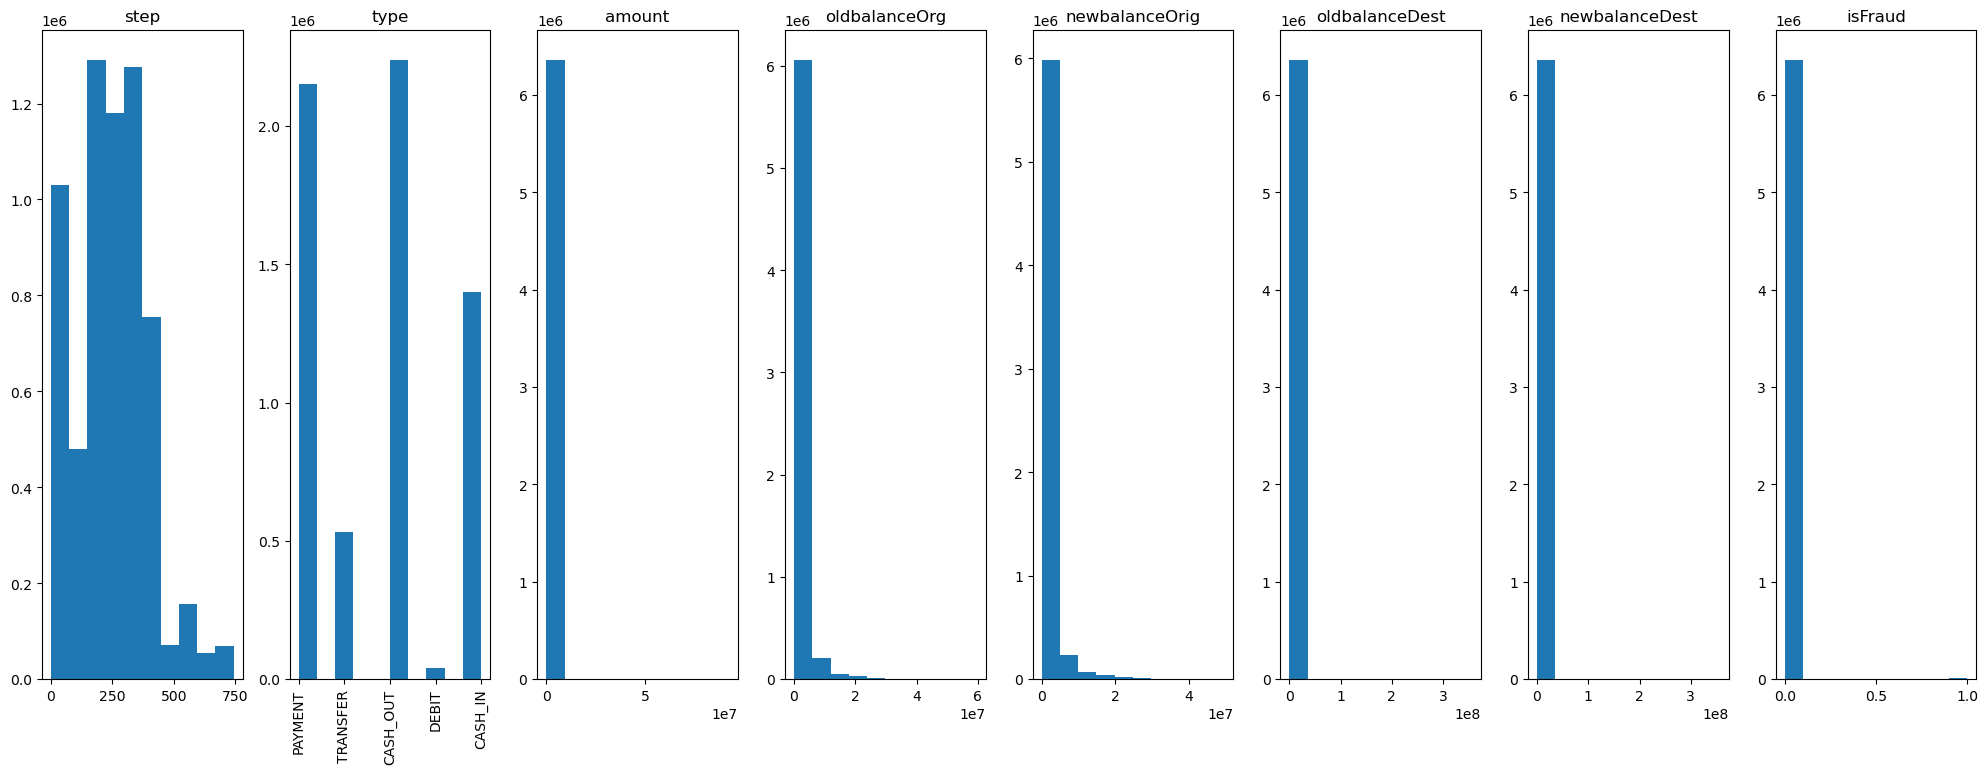

In [8]:
#Create a histogram for each column separately 
fig,axes = plt.subplots(ncols=8, figsize=(20,8))
for col,ax in zip(df.columns, axes):
    ax.hist(df[col])
    ax.set_title(col)
    if col=='type':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)        
plt.tight_layout()

**Data Sampling** <br> 
Using stratified shuffle splitting to extract a smaller sample of 100,000 entries only whilst simultaneously maintaining the same class distribution as the original 


In [9]:
#Identify the target coloumn 
target = 'isFraud'
#stratified sampling and obtaining a new, smaller dataframe 
sample_inx, _ = next(StratifiedShuffleSplit(n_splits=1, train_size=100000, random_state=rs).split(df[df.columns.drop(target)], df[target]))
x_data, y_data = df.loc[sample_inx, df.columns[:-1]], df.loc[sample_inx, df.columns[-1:]]
df = pd.concat([x_data, y_data], axis=1).reset_index(drop=True)

#report data shape again
shape = df.shape
print('Number of coloumns:', shape[1])
print('Number of rows:', shape[0])


Number of coloumns: 8
Number of rows: 100000


In [10]:
#preview first 10 entries
df.head(10)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,163,CASH_IN,148753.50,24482.00,173235.50,315720.90,166967.40,0
1,15,PAYMENT,10180.55,8680.01,0.00,0.00,0.00,0
2,129,PAYMENT,14806.33,25871.46,11065.14,0.00,0.00,0
3,181,PAYMENT,38336.09,10445.00,0.00,0.00,0.00,0
4,163,CASH_OUT,188096.77,0.00,0.00,391329.68,579426.45,0
5,228,CASH_OUT,231247.60,49900.00,0.00,0.00,231247.60,0
6,283,CASH_OUT,28778.92,14316.00,0.00,106610.16,135389.09,0
7,139,CASH_OUT,153207.00,0.00,0.00,618991.42,772198.41,0
8,311,PAYMENT,13299.61,0.00,0.00,0.00,0.00,0
9,43,CASH_IN,65588.77,331946.19,397534.96,1014731.07,949142.30,0


As seen, now we have a smaller dataset with only 100,000 online transactions. Now let's look at the data distribution once again to make sure it resembles the original dataset. 

Data distribution after data splitting:

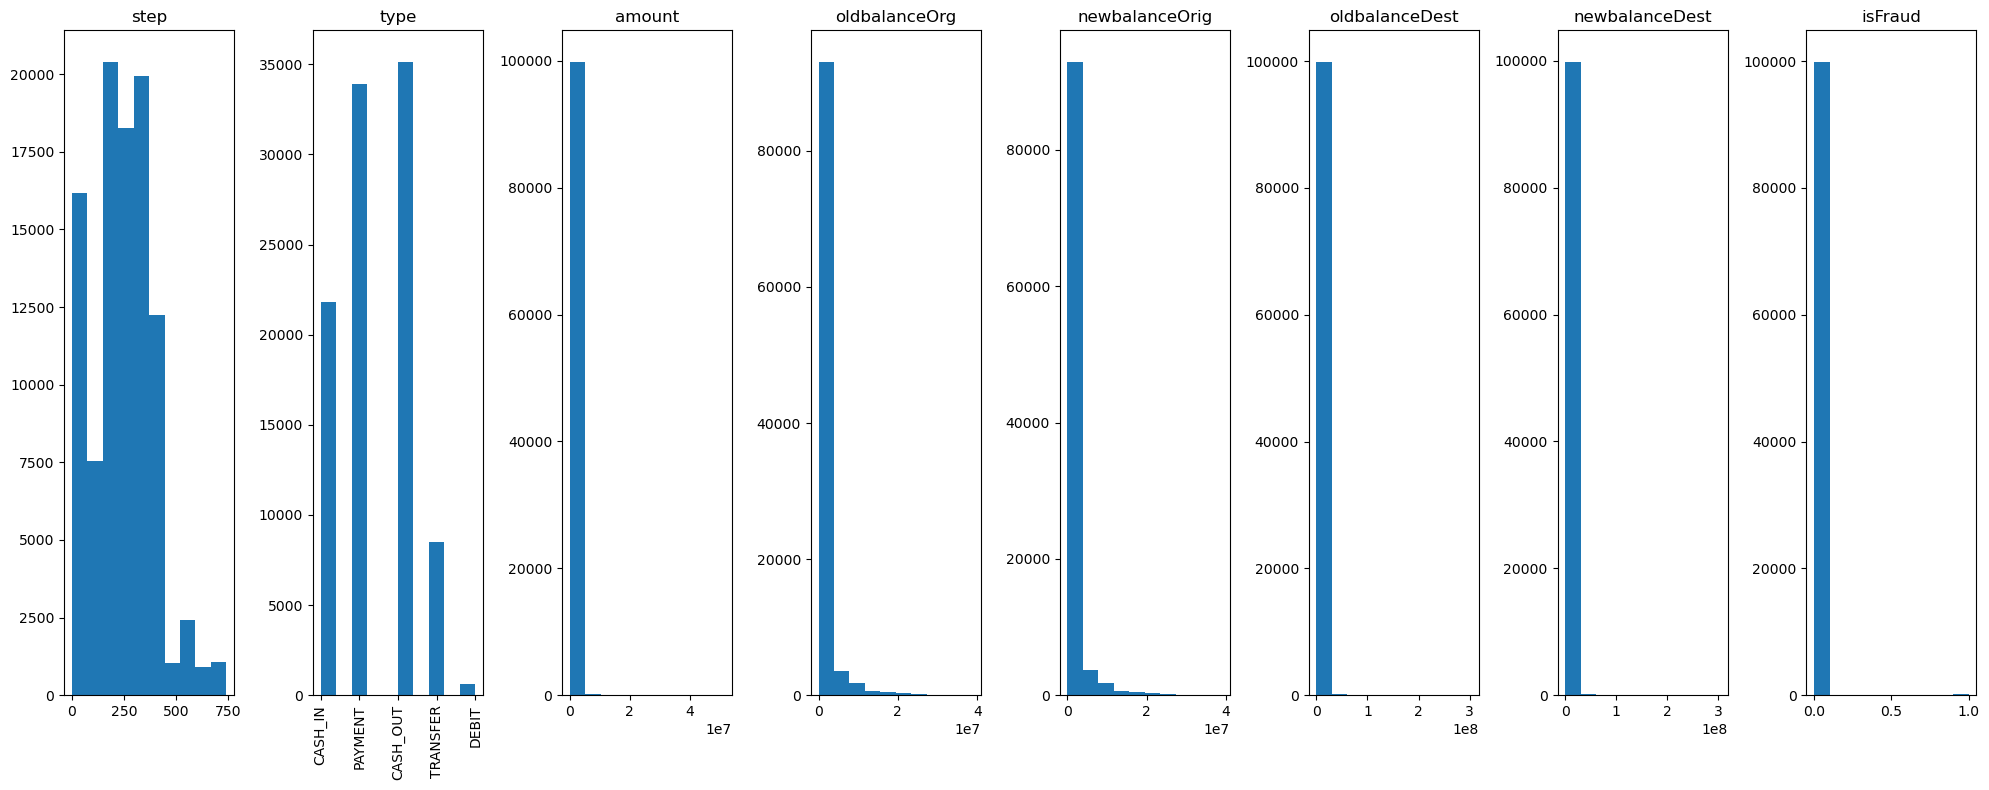

In [11]:
#Create a histogram for each column separately 
fig,axes = plt.subplots(ncols=8, figsize=(20,8))
for col,ax in zip(df.columns, axes):
    ax.hist(df[col])
    ax.set_title(col)
    if col=='type':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)     
plt.tight_layout()

Indeed, as illustrated by the histograms above, the data sampling was sucessful. Now we have a smaller dataset that has much the same distribution and characteristics as the original, with the only difference between the two graphs being the frequency counts given the differences in size. That way we are quite sure than no important data is lost. Next I will move to exploratory data analysis.

## Part Two: Exploratory Data Analysis
<br>

**In this section, I will explore the data in more detail to make sure there are no missing or null entries, check the data type of each variable, and, importantly, get a better understanding of the important variables in the dataset and how they relate to our main question of what makes a transaction fraudulent.**
<br>


**Descriptive Statistics**

In [12]:
#Get statistical summary of data 
df.describe().apply(lambda x:round(x,2)).T


,count,mean,std,min,25%,50%,75%,max
step,100000.0,242.98,141.78,1.00,156.00,238.00,334.00,7.400000e+02
amount,100000.0,179709.72,576598.21,0.28,13335.11,74516.04,209161.04,5.139181e+07
oldbalanceOrg,100000.0,820600.45,2851747.36,0.00,0.00,14210.50,107276.50,3.893942e+07
newbalanceOrig,100000.0,841607.63,2887882.97,0.00,0.00,0.00,145449.68,3.894623e+07
oldbalanceDest,100000.0,1096373.43,3428704.69,0.00,0.00,129868.85,943428.41,3.023942e+08
newbalanceDest,100000.0,1221523.22,3692353.29,0.00,0.00,211519.66,1115671.53,3.025609e+08
isFraud,100000.0,0.00,0.04,0.00,0.00,0.00,0.00,1.000000e+00


**Checking the data type**
<br>

In [13]:
#check data types and values count
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   oldbalanceOrg   100000 non-null  float64
 4   newbalanceOrig  100000 non-null  float64
 5   oldbalanceDest  100000 non-null  float64
 6   newbalanceDest  100000 non-null  float64
 7   isFraud         100000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 6.1+ MB


In [14]:
#Making sure there are no missing or null entries 
print(f'Number of missing entries per coloumn:\n{df.isnull().sum()}')
print()


Number of missing entries per coloumn:
step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64



It seems that there are no missing entries in the data and all the data have the correct format.

**Identifying variables that need preprocessing**

In [15]:
#Get the total number of unique values for each variable (& data type)
for col in df.columns:
    print(f'{col} ({df[col].dtype}): {len(df[col].unique())}')


step (int64): 468
type (object): 5
amount (float64): 99573
oldbalanceOrg (float64): 54156
newbalanceOrig (float64): 43123
oldbalanceDest (float64): 57379
newbalanceDest (float64): 61581
isFraud (int64): 2


We can see all of our variables are continuous variables, except for the two variables: 'type', which specifies the type of transaction, and the target variable, 'isFraud'. Now I take a closer look at some of the important variables in the data and how they relate to the target variable.  

**Bivariate Analysis**

First, I will look at the relationship between the mode or type of money transaction and fraud to see which transaction type is most common with fraud cases, followed by examining the relationship between fraud and transaction amounts, and lastly, the relationship between fraud and the victim's account balance before and after the transaction as well as the relationship between fraud and the perpetrator's account balance before and after the transaction.

**Relationship between type of transaction and fraud**

<Axes: >

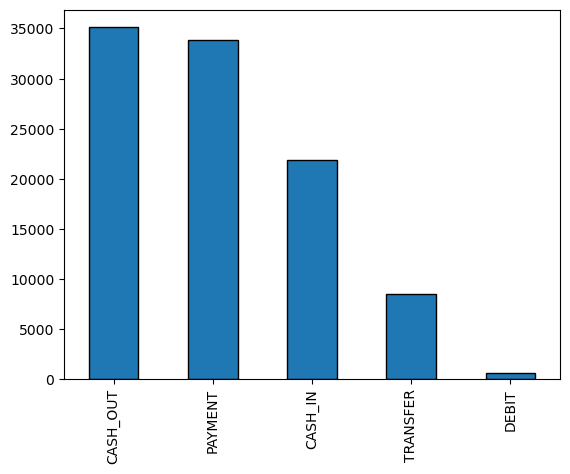

In [16]:
#Check frequency of each type of transaction again
df['type'].value_counts().plot(kind='bar', edgecolor='k')


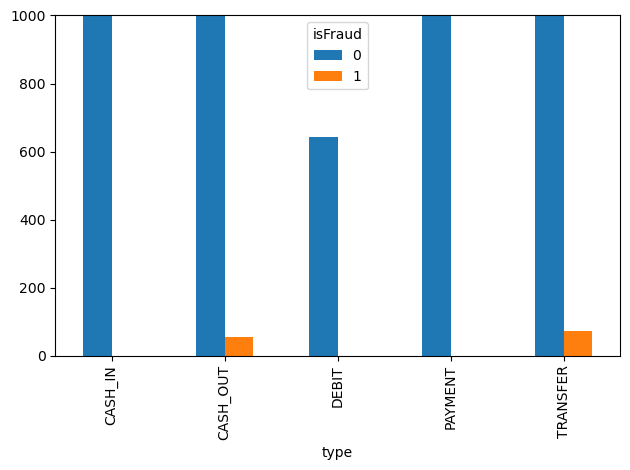

In [17]:
#Show fraud count by type of transaction (looking at a maximum count of 1000 only for comparison)
fraud_by_type = pd.crosstab(index=df['type'],columns=df['isFraud'])
fraud_by_type.plot(kind='bar', ylim=[0,1000])
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.tight_layout()

We can see that fraud transactions are almost exclusively transfer or cash-out transactions, with slightly more case of transfer transactions, but none of the other transaction types.

**Relationship between amount of money transferred and fraud**

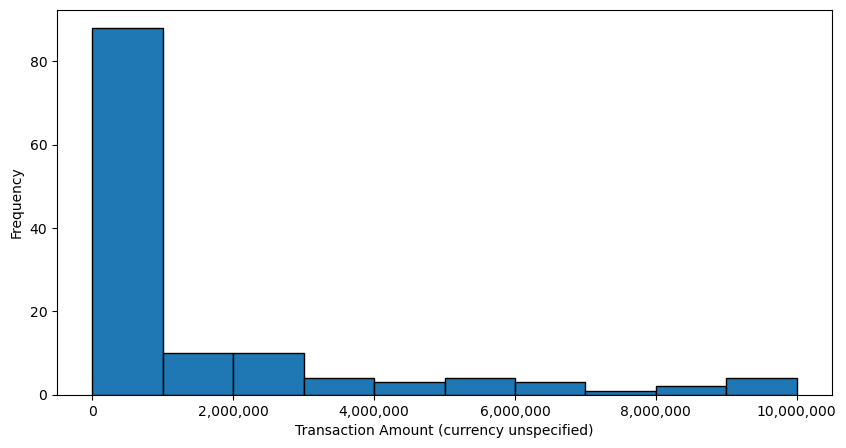

In [18]:
#Get dataframe with only fraud cases
df_fraud = df[df['isFraud']==1]

#Sort dataframe by amount 
fraud_by_amount = df_fraud.sort_values(by=['amount'], ascending=False)

#Create a histogram to show distribution of transaction amounts for fraud cases 
fraud_by_amount['amount'].plot(kind='hist', figsize=(10,5), edgecolor='black')
plt.xlabel('Transaction Amount (currency unspecified)')
plt.gcf().axes[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


We can gather from the histogram above that most fraud transactions are in the range of 0–1,000,000, making up approximately 85 cases, followed by the ranges from 1,000,000–2,000,000 and from 2,000,000 to 3,000,000, making up approximately 10 cases each, and then less and less for the ranges onwards. Although, strinkingly, there are cases of fraud that span up to the 10 million range! Unfortunately, information about the kind or value of the currency in this dataset was not disclosed by the publisher. Next I will look at the relationship between fraud and the sender's account balance before vs. after the transaction.


**Relationship between fraud and sender's balance before and after transaction**

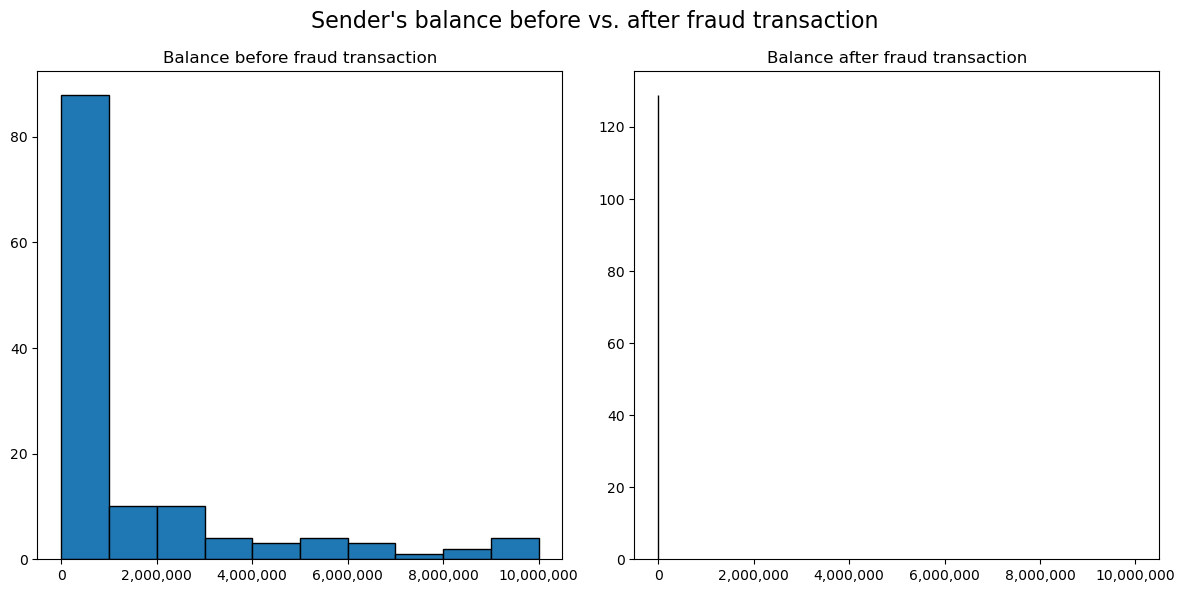

In [19]:
#Sort data by balance before transaction 
fraud_by_SenderBalanceBefore = df_fraud.sort_values(by=['oldbalanceOrg'], ascending=False)
fraud_by_SenderBalanceBefore = fraud_by_SenderBalanceBefore['oldbalanceOrg']

#Sort data by balance after transaction  
fraud_by_SenderBalancAfter = df_fraud.sort_values(by=['newbalanceOrig'], ascending=False)
fraud_by_SenderBalanceAfter = fraud_by_SenderBalancAfter['newbalanceOrig']

#Create histogram for sender's balance before vs. after transaction 
fig,ax = plt.subplots(1,2, figsize=(12,6), sharex=True)
ax[0].hist(fraud_by_SenderBalanceBefore, edgecolor='black')
ax[1].hist(fraud_by_SenderBalanceAfter, edgecolor='black')
fig.suptitle('Sender\'s balance before vs. after fraud transaction', fontsize=16)
ax[0].set_title('Balance before fraud transaction')
ax[1].set_title('Balance after fraud transaction')
plt.gcf().axes[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.gcf().axes[1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()


As illustrated, on the left, we see the distribution of money in the fraud victims' accounts before the fraudulent transaction, with varying amounts spreading out across multiple ranges, from 0 to 10 million. Notably, however, in the great majority of cases, the victim's account before the transaction has a low balance, falling in the lowermost range of 0-1,000,000. On the right, we see the distribution of money in the victims' accounts after the transaction; and the results are striking: it seems that all fraud cases in the dataset (at least in this partition of the set) involve completely draining out the victim's account, leaving them penniless. Interestingly, this maps perfectly onto the 'amount' histogram above, in which we saw the transaction amounts in fraud cases exhibiting an almost identical distribution! Now let's examine the perpetrator's account balance before and after a fraud transaction as well.

**Relationship between fraud and recipient's balance before and after transaction**

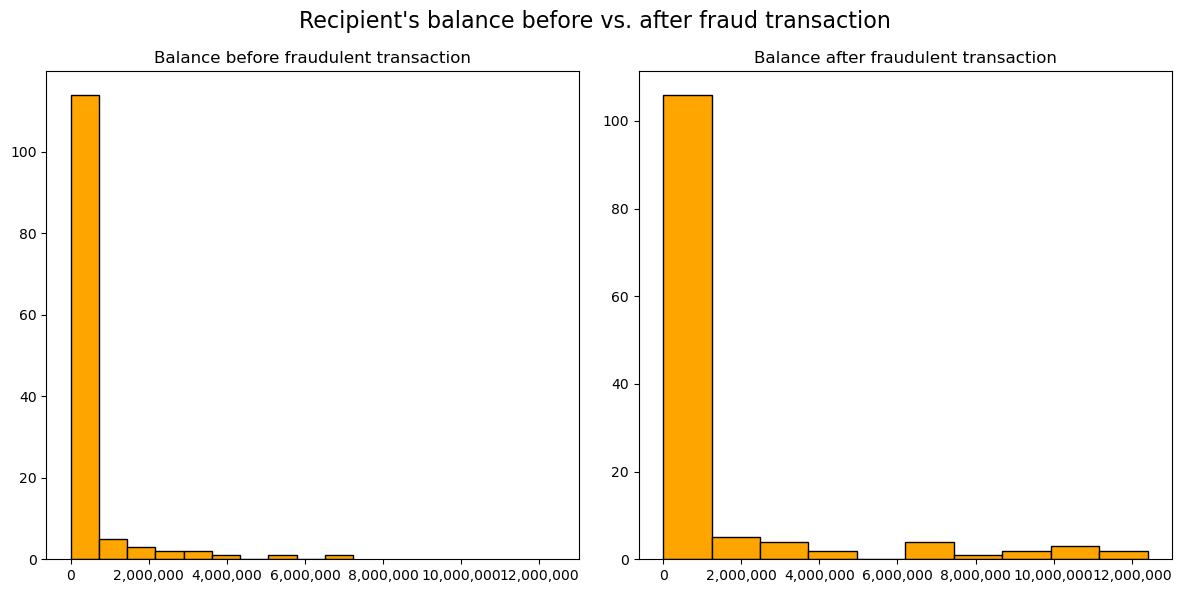

In [20]:
#Sort data by recipient's balance before transaction 
fraud_by_RecipientBalanceBefore = df_fraud.sort_values(by=['oldbalanceDest'], ascending=False)
fraud_by_RecipientBalanceBefore = fraud_by_RecipientBalanceBefore['oldbalanceDest']

#Sort data by recipient's balance after transaction  
fraud_by_RecipientBalancAfter = df_fraud.sort_values(by=['newbalanceDest'], ascending=False)
fraud_by_RecipientBalanceAfter = fraud_by_RecipientBalancAfter['newbalanceDest']

#Create histogram for recipient's balance before vs. after transaction 
fig,ax = plt.subplots(1,2, figsize=(12,6), sharex=True)
ax[0].hist(fraud_by_RecipientBalanceBefore, color='orange', edgecolor='black')
ax[1].hist(fraud_by_RecipientBalanceAfter, color='orange', edgecolor='black')
fig.suptitle('Recipient\'s balance before vs. after fraud transaction', fontsize=16)
ax[0].set_title('Balance before fraudulent transaction')
ax[1].set_title('Balance after fraudulent transaction')
plt.gcf().axes[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.gcf().axes[1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()


As shown, the fraud perpetrator's account balance before the transaction is very likely to be comparatively very low in balance, with their balance falling in the lowermost range of 0 to 1,000,000, and very rarely in the ranges onwards. On the right, their account balance after the transaction is also most likely to fall in the lowermost range (of 0-1,000,000), however we see higher balances post-transaction more frequently, which evidently indicates the success of their fraud for larger amounts. Curiously, I would speculate that the high frequency of low account balance post-transaction is likely evidence that most fraud transactions involve comparatively low amount anyway, as demonstrated by the transaction amount histogram from earlier. At any rate, now that we have a better insight into our data, I will proceed  to perform some data preprocessing and preparation before building the classification models that can detect fraud.

## Part Three: Data Preprocessing 
<br>

**In this section, I will make the necessary preperations and preprocessing for the data to make sure it is ready for analysis and model development. This will involve: performing one-hot encoding on the categorical variable, 'type' to make it viable for numerical analysis; data selection and splitting to obtain a training set for modeling and a testing set for model evaluation; feature scaling to normalize the scales of the numerical variables, such that all the variables would have equivalent scales, facilitating their processing and comparison between them; and finally, performing oversampling to balance the classes in the dataset before building the models.**
<br>


**Dealing with Categorical Variables: One-Hot Encoding** <br>

First off, I will perform one-hot encoding on the categorical variable, 'type', to convert its values to numeric type data to make it viable for numerical analysis and modeling. Briefly, one-hot encoding involves creating new, binary categories for each of the unique values in a given categorical variable, assigning 1 to flag its presence or 0 for its absence.

In [21]:
#one-hot encoding the 'type' coloumn
df = pd.get_dummies(df, columns=['type'], drop_first=True, dtype='int')

#examine shape again 
print('Data shape:', df.shape, '\n\n') 
#preview the data again 
df.head()


Data shape: (100000, 11) 




,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,163,148753.50,24482.00,173235.50,315720.90,166967.40,0,0,0,0,0
1,15,10180.55,8680.01,0.00,0.00,0.00,0,0,0,1,0
2,129,14806.33,25871.46,11065.14,0.00,0.00,0,0,0,1,0
3,181,38336.09,10445.00,0.00,0.00,0.00,0,0,0,1,0
4,163,188096.77,0.00,0.00,391329.68,579426.45,0,1,0,0,0


**Data Selection**<br>
Identifying the predictors and target variable

In [22]:
#Label the classes for later analysis 
classes = ['Not Fraud', 'Fraud']

#Identify predictors and target variable
features = df.columns.drop(target) 
x_data = df[features]
y_data = df[target]


**Examine Class Distribution**<br>

We can check the distribution of classes for the target variable, 'isFraud', to see the proportion of the majority class to that of the minority class.

The percentage of normal vs. fraudulent transactions:

0    99.871%
1     0.129%
Name: isFraud, dtype: object 




<Axes: xlabel='isFraud', ylabel='count'>

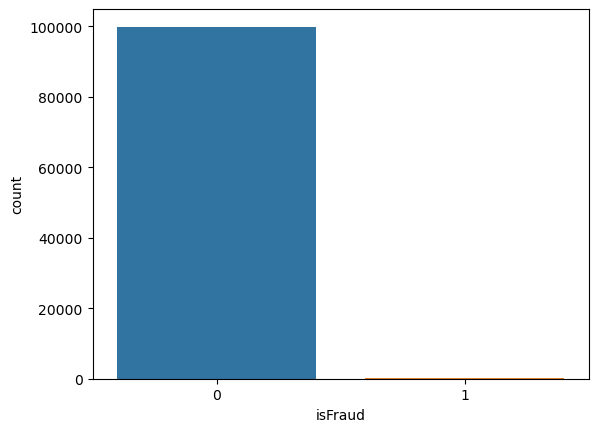

In [23]:
#Get percentage of the non-fraud vs. fraud cases in the dataset
print('The percentage of normal vs. fraudulent transactions:\n')
print(y_data.value_counts(normalize=True).apply(lambda x: str(x*100)+'%'),'\n\n')
#Visualizing the class distribution in the data using count plot
sns.countplot(x=y_data)


As illustrated, the two classes are extremely unbalanced, with fraud cases making up only about 0.13%! As such, I will now perform stratified data splitting, which ensures that the same proportion of each class in the target is represented in the training and testing sets followed by oversampling in order to ensure that the two classes in the dataset are balanced and of the equivalent proportions.

**Data Splitting** <br>

I will now split the data into a training and testing sets for model training and evaluation. Particularly, I will perform stratified data splitting which preserves the class distribution when splitting, such that both the training and testing sets would have the same class distribution as the original. As such, I will preserve 80% of the data for training and the remaining 20% for testing.

In [24]:
#Performing stratified data splitting (80% training/20% testing)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, stratify=y_data, random_state=rs)

#check the sizes of the training and testing sets
print('Number of training samples:', x_train.shape[0])    
print('Number of testing samples:', x_test.shape[0])

Number of training samples: 80000
Number of testing samples: 20000


**Feature Scaling** <br>

Now, given that the features in the dataset have differing scales, with values falling into vastly different ranges (e.g., amount of money vs. transaction time in hours), I will perform feature scaling to ensure that the diversity of scales doesn't affect analysis and the development of certain models like K-nearest neighbors classifiers. Feature scaling would also speed up processing for other models. To scale the features, I will employ feature normalization which redistributes the values on a scale from 0 to 1.

In [25]:
#First, identify numerical variables only for feature normalization 
numeric_vars = [col for col in df.columns if len(df[col].unique())!=2] 

#feature scaling numerical features 
Scaler = MinMaxScaler()
x_train[numeric_vars] = Scaler.fit_transform(x_train[numeric_vars])
x_test[numeric_vars] = Scaler.transform(x_test[numeric_vars])


In [26]:
#now we can look at the distribution of data after rescaling 
x_train.describe().drop(['25%','50%','75%']).apply(lambda x:round(x,2)).T


,count,mean,std,min,max
step,80000.0,0.33,0.19,0.0,1.0
amount,80000.0,0.00,0.01,0.0,1.0
oldbalanceOrg,80000.0,0.02,0.07,0.0,1.0
newbalanceOrig,80000.0,0.02,0.07,0.0,1.0
oldbalanceDest,80000.0,0.00,0.01,0.0,1.0
newbalanceDest,80000.0,0.01,0.02,0.0,1.0
type_CASH_OUT,80000.0,0.35,0.48,0.0,1.0
type_DEBIT,80000.0,0.01,0.08,0.0,1.0
type_PAYMENT,80000.0,0.34,0.47,0.0,1.0
type_TRANSFER,80000.0,0.09,0.28,0.0,1.0


As demonstrated in the above table, now all the features have the same scale, with a minimum value of 0 and a maximum of 1.

**Dealing with Imbalanced Classes: Oversampling** <br>

Now as discussed earlier, the classes in the dataset are extremely imbalanced, with the fraud cases that we're interested in predicting making up only about 0.13% of cases. This would pose a considerable obstacle for our current task, particularly as most models are generally biased towards maximizing prediction accuracy, which implies that they will likely learn the 99% of non-fraud cases at the expense of the less than 1% of fraud cases. Whilst this is completely reasonable for most cases, for cases such as the current one, where the target class we're interested in predicting makes up 1% or less, this completely defeats the purpose. As such, to deal with this problem, and ensure that the models to be developed learn as much about the fraud cases as about the non-fraud ones, I will apply oversampling. <br>
Oversampling involves generating novel data points for the minority class until it's equivalent in size to the majority class. There are different ways of doing this, such as random oversampling, synthetic oversampling (SMOTE), or adaptive synthetic oversampling (ADASYN), which involves duplicating rows from the minority class, as is the case with random oversampling, or advising intricate ways for generating completely new data points that exhibits more or less the same characteristics as the existing minority data, as with the diversity of synthetic oversampling techniques. Regardless of the technique, the final end is to balance the classes in the dataset by way of increasing the size of the minority class, which would allow better model learning and model prediction. Now, it's hard to tell in advance which technique would work best, and thus I will employ and test out different techniques, four in total, and compare and contrast them to identify the best oversampling technique for the current dataset. To do so, I will build a preliminary model, particularly, a logistic regression classifier, to get a baseline measure of classification validity, and then I will implement a loop that iterates over the four different techniques, balance the classes and train the classifier with each, and measuring the classifier performance for each technique individually. This will give us some idea about the best oversampling technique for the data. For evaluation, I will use the standard battery of error metrics, including precision, recall, and F-beta, however I will adjust the F-beta score to take a beta of 5, to try and prioritize recall for the fraud class and minimize false negatives, making the cost of falsely predicting fraud cases 5 times that of falsely predicting normal cases. Further, given that it's an imbalanced dataset, I will use the F-beta score as the primary guide for model performance (rather than accuracy which is typically maximized for such cases).

**Evaluating classification before oversampling** <br>
Developing a simple logistic regression classifier and evaluating its performance

In [27]:
#create logistic regression object
LR = LogisticRegression(solver='saga', random_state=rs, max_iter=500, n_jobs=10)
#fit the model
model = LR.fit(x_train, y_train)
#generate predictions
y_pred = model.predict(x_test)
#get error scores 
error_scores(y_test, y_pred, classes)


,Not Fraud,Fraud
Accuracy,1.0,1.0
Precision,1.0,0.0
Recall,1.0,0.0
F5,1.0,0.0


Indeed, we can see accuracy is (approximately) 1.0, which is typically the case with datasets such as the current one, as the model learns about the 99% of normal cases perfectly, at the cost of learning about the minority 1%. However, if we looked at the other metrics for the fraud class, precision, recall, and f5 score are all 0! Now I will evaluate different oversampling techniques for balancing the classes.

**Oversampling**

In [28]:
#Get samplers 
samplers = [('ROS', RandomOverSampler(random_state=rs)), ('SMOTE',SMOTE(random_state=rs)), 
            ('Borderline SMOTE', BorderlineSMOTE(random_state=rs)), ('ADASYN', ADASYN(random_state=rs))]

#create empty dictionary to store evaluation results 
results=[]

#loop over and test each oversampling technique on the logistic regression classifier 
for label,sampler in samplers:
    x_over, y_over = sampler.fit_resample(x_train, y_train)
    LR = LogisticRegression(solver='saga', random_state=rs, max_iter=500, n_jobs=10)
    model = LR.fit(x_over, y_over)
    y_pred = model.predict(x_test)
    #get error scores and store them 
    result = error_scores_dict(y_test, y_pred, label)
    results.append(result)

#Report the results
results_table = pd.DataFrame(results).set_index('Strategy')
results_table


,Accuracy,Precision,Recall,F5
Strategy,,,,
ROS,0.85,0.92,0.01,0.17
SMOTE,0.85,0.92,0.01,0.17
Borderline SMOTE,0.92,0.92,0.02,0.28
ADASYN,0.82,0.96,0.01,0.15


Ideally, we want strong recall for such user case, however not at the cost of precision. Thus, the F5 score is a better indicator for performance as it leverages both, with a tad more emphasis on recall. Accordingly, as indicated by the F5 scores here, Borderline SMOTE seems to be the most appropriate oversampling method for the data, raising the F-beta score to 0.28 for the fraud class, which is a significant feat considering the first model had an F-beta of 0. Now I will build different classifiers with borderline SMOTE-oversampled training data and simultaneously perform hyperparameter tuning on each in order to obtain the best performance out of each classifier and decide on the best one for our task.


**Borderline SMOTE** <br>

Now that we've determined that borderline SMOTE is the best oversampling method for our data, I will use it to perform oversampling on the training data one final time and use the new sets to train the upcoming classifiers 

The percentage of normal vs. fraudulent transactions:

0    50.0%
1    50.0%
Name: isFraud, dtype: object 




<Axes: xlabel='isFraud', ylabel='count'>

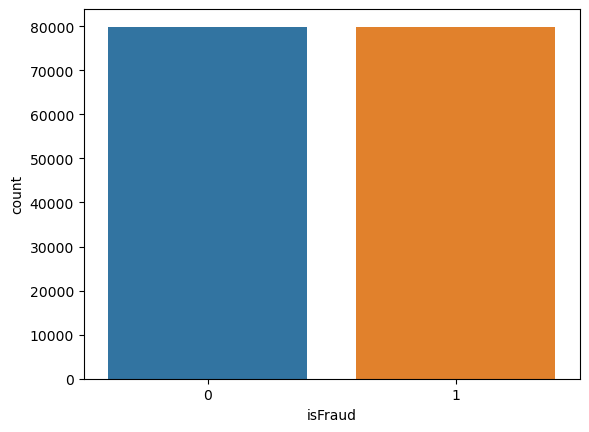

In [29]:
#Obtain new training data balanced with borderline SMOTE 
x_over, y_over = BorderlineSMOTE(random_state=rs).fit_resample(x_train, y_train)

#preview class distribution after oversampling  
print('The percentage of normal vs. fraudulent transactions:\n')
print(y_over.value_counts(normalize=True).apply(lambda x: str(x*100)+'%'),'\n\n')
sns.countplot(x=y_over)


As illustrated, both classes have the same size now and are perfectly balanced. Now I will move to model development, tuning, and selection.

## Part Four: Model Development, Tuning, and Evaluation 
<br>

**In this section, I will train and test different classification models to predict transaction fraud, which will include: logistic regression classifier, k-nearest neighbors (KNN) classifier, kernel support vector machines (SVM) classifier, and finally, a random forest classifier. To obtain the best performance out of each model, I will perform hyperparameter tuning via grid search with 4-fold cross validation. I will compare and contrast the performances of each using the same error metrics as above, and if necessary, I will develop a stacking ensemble model that leverages the strengths of the individual models by training a meta-model on their predictions to generate the final set of class predictions. The final model should ideally maximize recall as well as precision.**
<br>


### Model One: Logistic Regression classifier

**Model Development and Hyperparameter Tuning**

In [30]:
#Training and tuning a logistic regression classifier 
LR = LogisticRegression(solver='saga', max_iter=500, random_state=rs, n_jobs=10)
Grid_LR = GridSearchCV(LR, scoring='f1', cv=4, n_jobs=10, 
                            param_grid={
                                'penalty': ['l1', 'l2'], 
                                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                            }).fit(x_over, y_over)

#Report best parameters after grid search
print('Best parameter values for the logistic regression classifier:')
Grid_LR.best_params_


Best parameter values for the logistic regression classifier:


{'C': 100, 'penalty': 'l1'}

**Model evaluation**

In [31]:
#Get best estimator based off grid search 
LR_classifier = Grid_LR.best_estimator_

#Generate predictions
y_pred = LR_classifier.predict(x_test)

#Compute and report error scores  
print('Logistic Regression classification results:')
error_scores(y_test, y_pred, classes=classes)


Logistic Regression classification results:


,Not Fraud,Fraud
Accuracy,0.97,0.97
Precision,1.00,0.04
Recall,0.97,0.96
F5,0.97,0.54


As demonstrated, prediction for the fraud class was improved with regularized logistic regression (with L1 regularization and C=100) across most of the error measures, with a very high recall of 0.96 and an acceptable overall F5 score of 0.54. However, the precision score is still far from ideal. As mentioned, a good model would ideally maximize recall but not at the cost of precision. That is, we want to correctly predict or 'recall' actual cases of fraud but not at the cost of having many non-fraud cases misclassified as fraud. Thus, this low precision score indicates that we have many non-fraud cases classified wrongly as fraud. We can make more sense of these scores by visualizing the results using a confusion matrix.

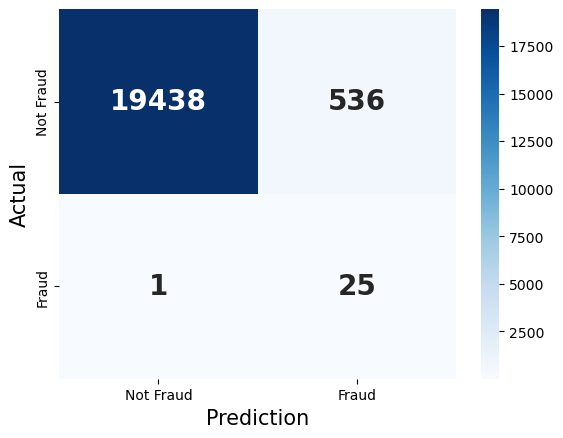

In [32]:
#Visualize confusion matrix
plot_cm(y_test, y_pred, classes)

As intuited, recall was very good for the fraud cases, with 25 cases classified correctly and only one fraud case misclassified! However, whilst the great majority of non-fraud cases were classified correctly, a considerable proportion were not, particularly when pitted against the number of correctly classified fraud cases (536 vs. 25). It would be more ideal if we had as many cases classified correctly as possible, for both classes. Let's see if we can improve classification, especially precision, with other models. Next I will develop and tune a KNN classifier. 

### Model Two: K-Nearest Neighbors classifier

**Model Development and Hyperparameter Tuning**

In [33]:
#Training and tuning a KNN classifier 
KNN = KNeighborsClassifier(weights='distance', n_jobs=10)
Grid_KNN = GridSearchCV(KNN, scoring='f1', cv=4, n_jobs=10,
                            param_grid={
                                'n_neighbors': range(1,11),
                            }).fit(x_over, y_over)

#Report best parameters after grid search
print('Best parameter values for the KNN classifier:')
Grid_KNN.best_params_


Best parameter values for the KNN classifier:


{'n_neighbors': 1}

**Model Evaluation**

In [34]:
#Get best estimator based off grid search 
KNN_classifier = Grid_KNN.best_estimator_

#Generate predictions
y_pred = KNN_classifier.predict(x_test)

#Report error scores 
print('K-Nearest Neighbors classification results:')
error_scores(y_test, y_pred, classes=classes)


K-Nearest Neighbors classification results:


,Not Fraud,Fraud
Accuracy,1.0,1.00
Precision,1.0,0.28
Recall,1.0,0.65
F5,1.0,0.62


As illutrated, the KNN classifier was not particularly better than the logistic regression one, however it managed to balance recall and precision better than the earlier model did. Particularly, whilst recall was decreased, falling from 0.96 to 0.65, precision was improved significantly, rosing to 0.28 from 0.04. This means that we likely have less fraud cases predicted correctly, however less non-fraud cases was classified incorrectly! I will again use a confusion matrix to visualize the results.

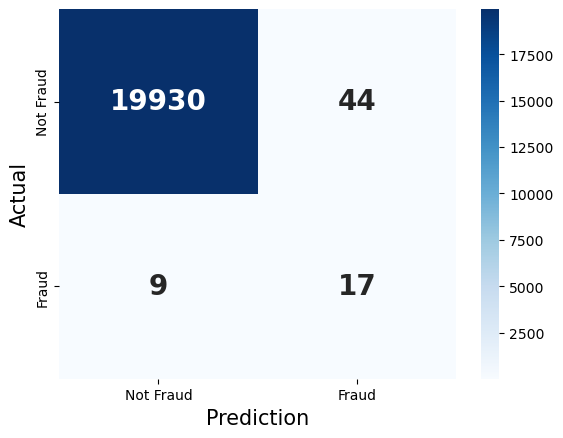

In [35]:
#Visualize confusion matrix
plot_cm(y_test, y_pred, classes)


Indeed, we can see significantly less cases of normal transactions misclassified as fraudulent, going down from 536 instances earlier to only 44 instances now. However, unfortunately, recall for the fraud instances was also decreased significantly, falling from 25 to 17, which is not a trivial number considering that the fraud cases make up only 26 in total! We need a better model. Next I will develop and test out a support vector machines classifier.

### Model Three: Kernel SVM classifier 

Now I will develop a kernel SVM classifier, which will try to identify a hyperplane that best separates the classes within the feature space, maximizing the distance between the two classes by maximizing the margin lengths separating the classes on that hyperplane. It should work better than logistic regression if the data is complex. Further, since the dataset is medium and size and the number of features is small, I have decided to use an rbf kernel. Note however, again, given the limited computational sources and given that kernel SVMs are very computationally costly, especially also with a dataset of 100,000 entries, I will perform kernel approximation with Nystroem sampler, rather than processing the entire dataset to define the kernel function. Kernel approximation, as the name implies, would try to approximate the true kernel function from only a small sample of the data. As such, I will use the Nystroem sampler to approximate the rbf kernel from only 500 samples, before building and tuning a SVM classifier with the obtained data.

**Kernel Approximation**

In [36]:
#Create an instance of Nystroem class and set characteristics
NystroemSVC = Nystroem(kernel='rbf', n_components=500, random_state=rs, n_jobs=10)
#Fit and transform the data
x_train_aprx = NystroemSVC.fit_transform(x_over)
x_test_aprx = NystroemSVC.transform(x_test)


**Model Development and Hyperparameter Tuning**

In [37]:
#Training and tuning a kernel SVM classifier 
linearSVC = LinearSVC(random_state=rs)
Grid_SVC = GridSearchCV(linearSVC, scoring='f1', cv=4, n_jobs=10,
                            param_grid={
                                'penalty': ['l1', 'l2'], 
                                'C': [0.01, 0.1, 1, 10, 100]
                            }).fit(x_train_aprx, y_over)

#Report best parameters after grid search
print('Best parameter values for the kernel SVM classifier:')
Grid_SVC.best_params_



Best parameter values for the kernel SVM classifier:


{'C': 10, 'penalty': 'l2'}

**Model Evaluation**

In [38]:
#Get best estimator based off grid search 
SVC_classifier = Grid_SVC.best_estimator_

#Generate predictions
y_pred = SVC_classifier.predict(x_test_aprx)

#Report error scores
print('Kernel SVM classification results:')
error_scores(y_test, y_pred, classes=classes)


Kernel SVM classification results:


,Not Fraud,Fraud
Accuracy,0.97,0.97
Precision,1.00,0.04
Recall,0.97,0.88
F5,0.97,0.49


As seen from the results, the rbf kernel SVM classifier obtained a high recall of 0.88 and overall F5 score of 0.49, however precision was pretty low, equaling 0.04. These results in fact closely resemble the results of the logistic regression classifier, which had almost identical scores. This means that once again we probably have many non-fraud instances misclassified as fraudulent. A confusion matrix would come in handy.

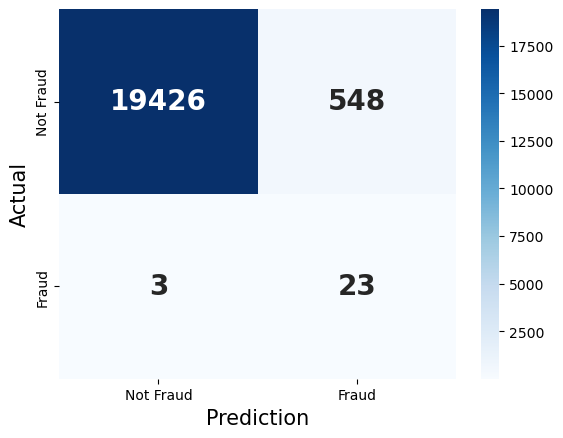

In [39]:
#Visualize confusion matrix
plot_cm(y_test, y_pred, classes)


Indeed, the matrix here closely resembles the one obtained with the logistic regression model, but with 2 less fraud cases being classified correctly. Thus, we can't say that the kernel SVM classifier was any better for our data, nor did it make different or better contributions to help detect fraud better. We can still do better. Next, I will develop one final model, a random forest classifier, and again perform hyperparameter tuning to optimize the number of decision trees, and evaluate the results to see if it performs better than the models developed thus far. 

### Model Four: Random Forest 

**Model Development and Hyperparameter Tuning**

In [40]:
#Training and tuning a random forest model 
RF = RandomForestClassifier(random_state=rs, max_depth=10, n_jobs=10)
Grid_RF = GridSearchCV(RF, scoring='f1', cv=4, n_jobs=10,
                            param_grid={'n_estimators': [50, 100, 200, 300, 400]}).fit(x_over, y_over)

#Report best parameters after grid search
print('Best parameter values for the random forest classifier:')
Grid_RF.best_params_


Best parameter values for the random forest classifier:


{'n_estimators': 50}

**Model Evaluation**

In [41]:
#Get best estimator based off grid search
RF_classifier = Grid_RF.best_estimator_

#Generate predictions 
y_pred = RF_classifier.predict(x_test) 

#Report error scores
print('Random Forest classification results:')
error_scores(y_test, y_pred, classes=classes)


Random Forest classification results:


,Not Fraud,Fraud
Accuracy,1.0,1.00
Precision,1.0,0.44
Recall,1.0,0.92
F5,1.0,0.89


Based on the obtained results, the random forest classifier (with 50 trees) proved superior to all the previous models, especially in improving precision and balancing it against recall. As demonstrated, this classifier successfully managed to maximize not only recall, but also precision, obtaining a precision of 0.44, recall of 0.92, and an overall F5 score of 0.89. This is a huge improvement from before! What this effectively means is that classification is now more accurate for both classes, with most fraud cases being classified correctly (since recall is high) and fewer non-fraud cases being misclassified (since precision is high). Now let's examine the confusion matrix to get a better view of its performance. 

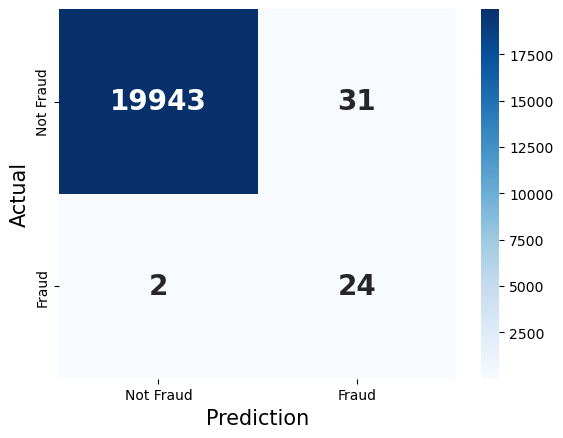

In [42]:
#Visualize confusion matrix
plot_cm(y_test, y_pred, classes)

Consistent with the above speculation, the confusion matrix for the random forest illustrates very good recall for the actual fraud cases, and very fewer cases of non-fraud misclassification, falling down to only 31 misclassification instances (from 536 misclassifications with the first model). Thus, the random forest classifier seems to be the best model for our data so far. Next, I will develop a stacking classifier, which would learn from the individual models developed and leverage their strengths to come up with the final set of predictions. As we have seen, the different models had different points of weakness and different points of strength. For instance, the logistic regression classifier had very good recall but very poor precision; the KNN classifier established some balance, improving precision significantly; and lastly, the random forest classifier improved both precision and recall however in a completely different way, i.e. by employing decision trees. We can get a quick view of how each model performed by visualizing and comparing the ROC curve of each. 

**Model Comparison** <br>
Plotting the ROC curve for each model and reporting their AUC score

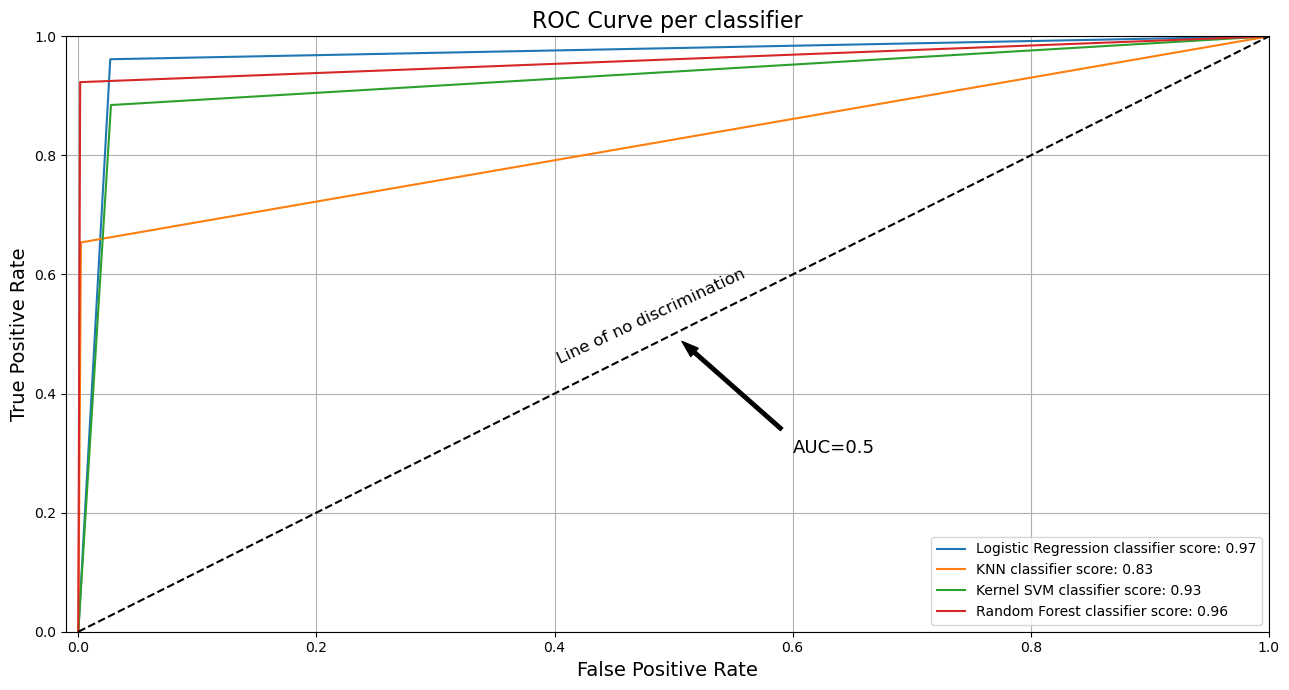

In [43]:
#Get list of estimators 
estimators_lst = [LR_classifier, KNN_classifier, SVC_classifier, RF_classifier]

#Plot ROC curve for each model 
plot_ROC_curve_multiple(x_test, x_test_aprx, y_test, estimators_lst)


As depicted by the above graph, the KNN classifier performed worst, with a comparatively low true positive rate, followed by the kernel SVM classifier, then the logistic regression classifier, and lastly we have the random forest classifier which performed best. Although the logistic regression model had higher true positive rate, it also had higher false positive rate, and thus the random forest classifier seems best as, altough it has slightly lower true positives, it minimizes the false positive rate to a minimum. Thus, we see different strengths and weaknesses associated with the different models, at least comparing the random forest to the logistic regression classifier. As such, employing a stacking classifier can help us learn from the strengths of each of these models to maximize the overall performance and help us in our mission of transaction fraud detection.

### Stacking Model

As mentioned, to get the best performance and obtain the most robust and reliable class predictions, I will employ here a stacking ensemble, which would leverage the strengths of the different models developed thus far by learning from their collective insights, combining their predictions to obtain the most robust set of predictions. Partiuclarly, I will develop a stacking classifier with a logistic regression meta-model, which will be trained on the predictions of the individual model, using them as training inputs to generate the final set of predictions for the data. However, given that the kernel SVM classifier did not make any noticeable contributions, performing much as the logistic regression one, I will not include it in the ensemble.

**Model Development**

In [44]:
#First, making a list of classifiers to incorporate into the ensemble 
estimators = [('LR', LR_classifier), ('KNN', KNN_classifier), ('RF', RF_classifier)]

#Using Stacking Classifier with a logistic regression meta-model
#create Stacking classifier object and specify a meta classifier 
SC = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=500), n_jobs=10)

#training the stacking classifier 
SC_classifier = SC.fit(x_over, y_over)


**Model Evaluation**

In [45]:
#Generate final class predictions
y_pred = SC_classifier.predict(x_test)

#Report error scores
print('Stacking classification results:')
error_scores(y_test, y_pred, classes) 


Stacking classification results:


,Not Fraud,Fraud
Accuracy,1.0,1.00
Precision,1.0,0.77
Recall,1.0,0.92
F5,1.0,0.92


 As speculated, the stacking model was successful at learning from the different individual models, producing the best results so far. In the above table, we have very good recall, 0.92, as well as the highest precision of all models, peaking at 0.77. We also obtained the best F5 score thus far, peaking to 0.92. This would indicate that we have very good classification for both classes, accurately predicting normal transaction cases as well as fraudulent transaction cases in great numbers. I will visualize the confusion matrix one last time to make better sense of the results. 

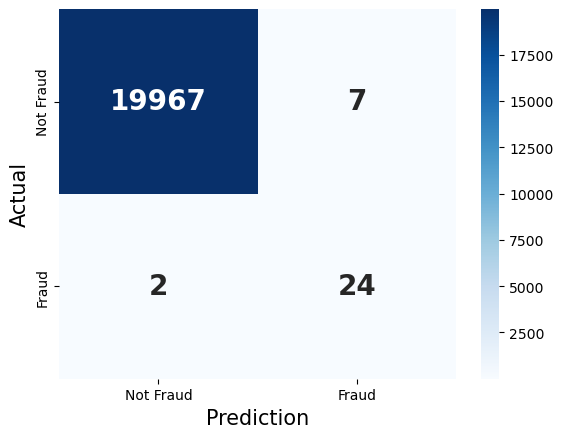

In [46]:
#Visualizing confusion matrix
plot_cm(y_test, y_pred, classes)


As demonstrated, the stacking classifier indeed improved classification for both classes in the dataset: the great majority of normal transaction cases were classified correctly, with only 7 cases of misclassification, the same with the fraud class, correctly classifying or detecting the great majority of fraud instances with only 2 instances of misclassification. We can also examine the resulting ROC curve for this stacking classifier.

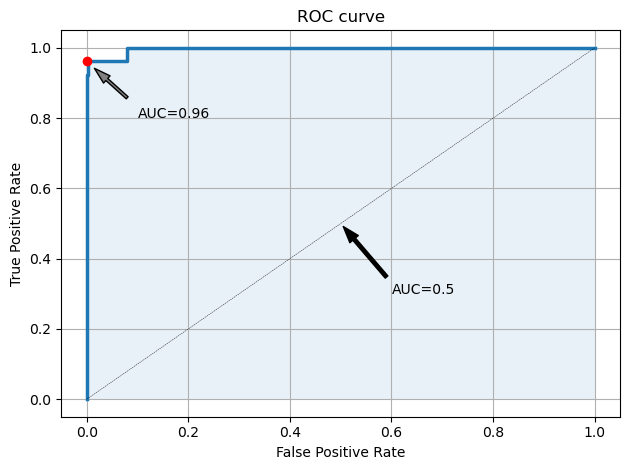

In [47]:
#Visualize ROC curve 
plot_ROC_curve(SC_classifier, x_test, y_test)

Evidently, revealed here, as in the confusion matrix above, overall the stacking classifier reduced the false positive rate to a minimum, with only a slight decline in the true positive rate, resulting in quite a large area under the curve. As annotated, the final AUC score for the stacking classifier is 0.96, which is pretty excellent. Accordingly, we can reasonably deem this classifier the best candidate model for our current dataset, and select it as the final model to be deployed for transaction fraud detection.

In the next and final section, I will engage in model interpretation to try and understand the model better, and understand the basis upon which the model was performing its classification. That is, we need to understand which of the features exactly were most informative and most impactful on the final classification decision. Now given that the final stacking model we obtained is highly complex, if not impenetrable, composed of multiple different models, each with its own characteristics and classification processes, etc., we will not be able to interpret it directly. Indeed, this model would be considered a non-self-interpretable or "black-box" model. Thus, in order to be able to interpret it, I will employ different model interpretation techniques to understand the one we obtained better. These will be permutation feature importance and a partial dependence plot. 


## Part Five: Model Interpretation 
<br>

**In this section, as mentioned, I will apply model interpretation techniques to try and understand the model better. First, I will perform permutation feature importance, a technique which involves shuffling the values of a given feature multiple times and measuring error each time. This process is carried out multiple times with each feature, one feature at a time, whilst holding all the other features in check. If a feature is indeed important or highly impactful for the final model predictions, then shuffling its values should affect the model's performance significantly, usually by increasing its average error. This, as such, gives us an average estimate of how important each feature is for predicting the target class. Thus as a first step, permutation feature importance will give us a good idea about which factors were important in predicting transaction fraud. Second, after identifying the most important features, I will use a partial dependence plot to understand each individual feature better, and understand how or in which way it contributed to predicting transaction fraud. The partial dependence plot will basically give us a visualization of how the values (or cluster of values) of a given feature relate to the target class, fraud. It should give us a rough idea about the nature and direction of the relationship between a given feature and fraud detection. Some features migh have a positive relationship, such that increasing its values would increase the likelihood of fraud, others might have a negative relationship, whereby increasing its values would decrease the likelihood of fraud, and yet others might have more complicated relationships with the target, where some values would be associated with higher likelihoods of fraud whilst others will not, as we will see later on. That said, now I will move on to carrying out the first step of the analysis.**
<br>


### Permutation Feature Importance 
<br>
Now I will perform permutation feature importance (with 20 repeats) in order to determine which features are most important or impactful for predicting transaction fraud. Further, as the primary means of estimating error, I will use the F-score. After completing the permutation process, I will then get the mean importance score for each feature and visualize them using a box plot to get a visual representation of how each feature contributes to the model's performance.

In [48]:
#Calculate and store feature importances 
feature_importances = permutation_importance(estimator=SC_classifier, X=x_over, y=y_over, scoring='f1', 
                                             n_repeats=20, random_state=rs, n_jobs=10)

#get the shape of the resulting feature importances array 
print('Feature importances array shape:', feature_importances.importances.shape)

#Get the mean importances for each feature (mean of the n permutation repeats)
print('\n\nNumber of features:', len(feature_importances.importances_mean))
print('Mean feature importance for each feature:')
print(np.round(feature_importances.importances_mean,3))


Feature importances array shape: (10, 20)


Number of features: 10
Mean feature importance for each feature:
[0.075 0.104 0.309 0.059 0.029 0.073 0.142 0.    0.    0.248]


**Visualizing Feature Importances**

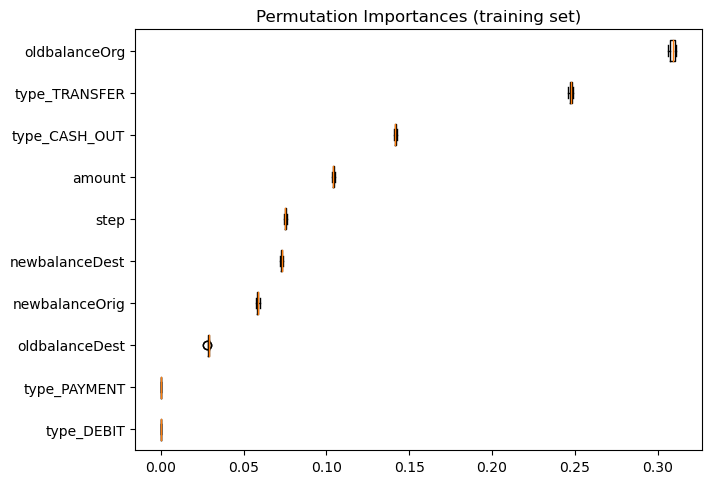

In [49]:
#Visualize the feature importances using a Box plot 
visualize_feature_importances(feature_importances, features)


As illustrated in the box plot, the most important features for determining transaction fraud are the sender's balance before the transaction ('oldbalanceOrg') and whether the the transaction was a transfer or not ('type_TRANSFER'), followed by whether the transaction was cash-out type ('type_CASH_OUT') and the amount being sent ('amount'), and then to a lesser degree, each of the features, step (time in hours), recipient's and sender's balance after the transaction ('newbalanceDest' and 'newbalanceOrig'), and the recipient's balance before the transaction ('oldbalanceDest'), respectively. The last two features, 'type_PAYMENT' and 'type_DEBIT', had no little to no impact on fraud prediction, evidently indicating that fraud cases mostly involve bank transfers or cash-out type transactions, but seldom involving payments or debit transactions, which is consistent with the preliminary analysis at the beginning, showing that all fraud cases were transfers or cash-out type transactions.<br>
That said, note that the box plot (& permutation feature importance) only tells us which features were most important and impactful on our predictions, however it doesn't tell us exactly in which way they did, or the direction of their relationship to the target. As such, next I will use a partial dependence plot to examine in more detail each of the important features identified individually, and understand the nature and direction of the relationship between each of these features and the target, fraud. 

### Partial Dependence Plot 
<br> 
As mentioned earlier, to better understand how each of the important features contributed to fraud prediction, I will use a partial dependency plot. This plot should provide a visual representation of how the values of a given feature relates or contributes to the predicted target, fraud, revealing the exact relationship between that feature and the target as well as the direction of the relationship. Note however, as two of the features, type_PAYMENT and type_DEBIT, proved irrelevant to fraud detection, I will remove them from analysis.

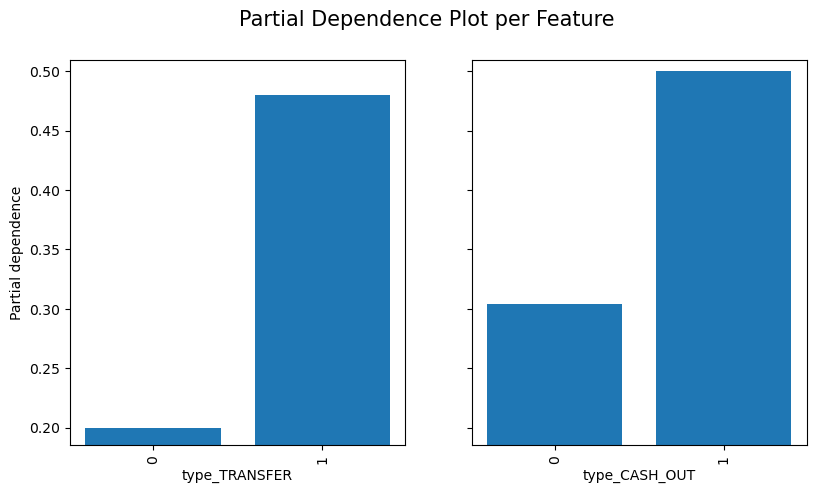

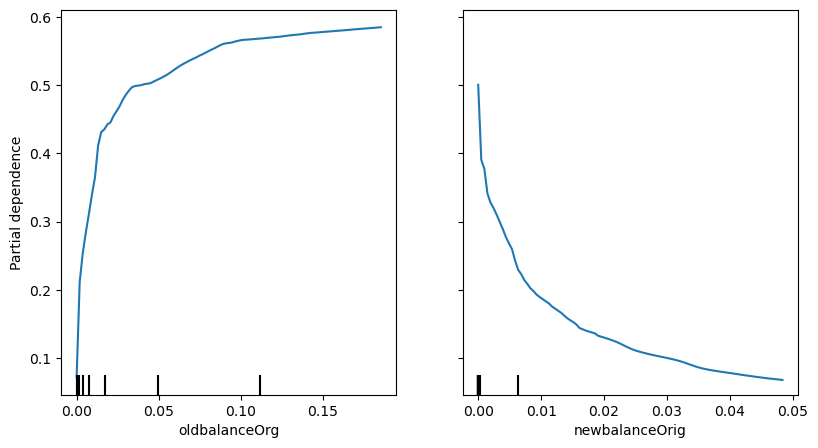

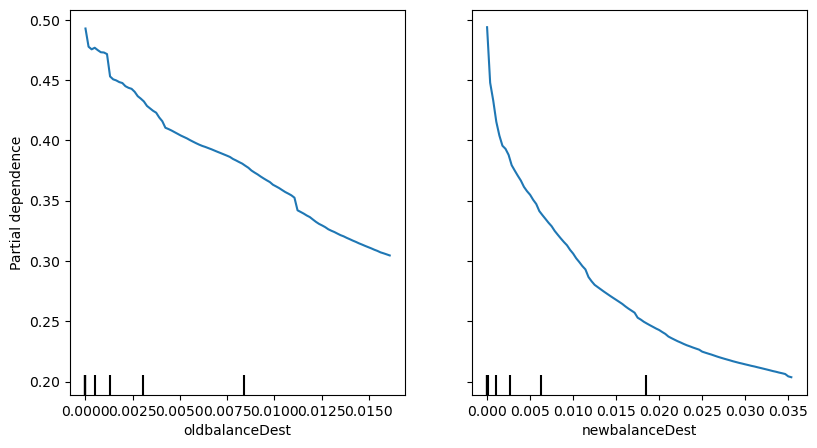

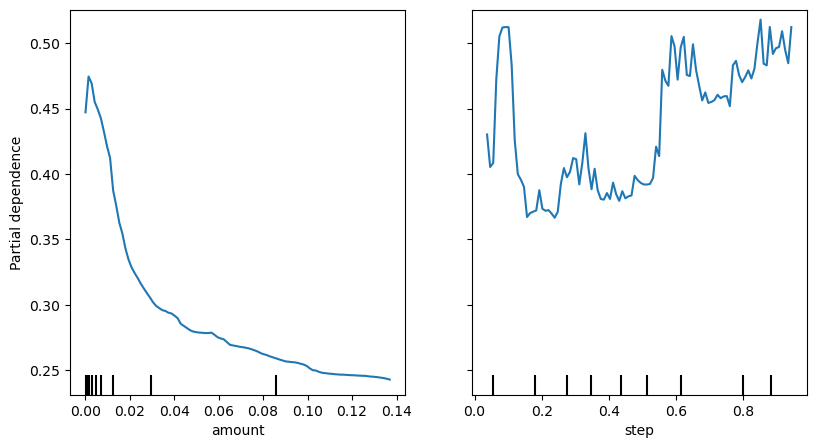

In [50]:
#List important features in pairs 
features_lst = [['type_TRANSFER', 'type_CASH_OUT'], ['oldbalanceOrg', 'newbalanceOrig'], 
                ['oldbalanceDest', 'newbalanceDest'], ['amount', 'step']]

#Create and display partial dependency plot for each of the listed features 
with plt.rc_context({'figure.figsize': (9.5, 5)}):
    pdp_plots = [PartialDependenceDisplay.from_estimator(estimator=SC_classifier, X=x_over, features=lst, categorical_features=features_lst[0], n_jobs=-1) for lst in features_lst]
    pdp_plots[0].figure_.suptitle('Partial Dependence Plot per Feature', fontsize=15)
    for ax in pdp_plots[0].axes_[0]:
        ax.set_xticks([0, 1])


**Interpretation**

&emsp;&ensp; The partial dependence plots for the features are presented in pairs, mostly in terms of relatedness. We have 8 plots in total depicting 8 relationships between the likelihood of fraud and a given feature. As demonstrated by the plots, some of the relationships are pretty intuitive. Starting off with the transaction types, consistent with the exploratory data analysis from earlier, and the previous box plot, most if not all fraudulent transactions are either transfers or cash-out, with comparatively more transfer cases, but rarely otherwise. This is plausibly the case because it is easier to to engage in fraud over distance, as over the internet, with the perpetrator's identity being hidden.
<br>

&emsp;&ensp; Moving to the sender's account balance before and after a transaction, we can see a positive relationship between the sender's account balance before a transaction and the likelihood of fraud, with the likelihood of fraud increasing as the account balance increases, before shortly stabilizing more or less, which is arguably because those with very low account balances (as seen above) are unlikely to be engaging in online shopping or buying. Nothing strange there. Conversely, we see a negative relationship between the sender's account balance after the transaction and the likelihood of fraud, which is again very consistent with the picture portrayed by the data analysis at the beginning, illustrating that all of the fraud transactions in our dataset involved completely draining the victim's account. This finding is thus being confirmed once again by the partial dependence plot. 
<br>

&emsp;&ensp; Turning to the recipient's account balance before and after a transaction, first we see a seemingly strong negative relationship between the recipient's balance before a transaction and fraud, with accounts having very low balance being associated with the highest likelihood of fraud. We also see a negative relationship between the recipient's account after a transaction and fraud, such that the higher the account balance the lower the likelihood that the transaction was fraudulent. Whilst counterintuitive, this finding makes sense when considering that the great majority of fraud transactions, as highlighted by the data analysis at the start, are typically in the lower ranges, especially the lowermost range of 0-1,000,000, compared to other non-fraudulent transactions, which might include transactions in tens of millions.
<br>

&emsp;&ensp; Similarly, moving on to the transaction amount plot, we can see again a negative relationship between amount and the likelihood of fraud, with, notably, the lowest transaction amounts being associated with the highest likelihood of fraud and the highest amounts being associated with the lowest likelihood of fraud. Again whilst preplexing at first glance, this is very consistent with the exploratory data analysis from earlier in which most fraud cases involved transactions in the lower range of 0-1,000,000, followed by, although to a much lower extent, the ranges of 1,000,000 to 2,000,000 and 2,000,000 to 3,000,000, with only a minority of transactions involving amounts in the higher ranges. And whilst these amounts are not necesseraily low in an absolute monetary sense, they're comparatively pretty low considering the range of transactions in this dataset, which peaks all the way up to about 51 million. However, again without knowing the exact type of currency here, we can't draw definitive conclusions. Generally, what we can gather from these findings so far, is that victims of fraud are perhaps likely to be lower to lower-medium income individuals. Finally, turning to the last plot, we see a more complicated relationship between the 'step' feature and fraud, in which the likelihood of fraud is increased when the number steps is very low or higher-medium to very high, and is significantly decreased when the number of steps is in the lower-medium to medium range. Now, this feature is described as a representing units of time, where 1 step = 1 hour, however the publisher of the dataset didn't exactly specify what these hours represent (e.g., is this the transaction processing time? etc.), and so there is little I can say about this feature. 
<br>

&emsp;&ensp; Overall, we have gathered some good clues and insights about fraudulent transactions. First, perpetrators of fraud are most likely to have a low or very low account balance before the transaction is made to their account. Second, the account balance of the victim is very likely to be completely drained and emptied out after a fraudulent transaction. Thus, if a transaction is made with all the money in the account, this should raise our suspicions that the transaction might be fraudulent. Third, most victims of fraud are likely to have a lower balance, suggesting that they might be low income or lower middle income individuals. However, in the absence of more information about the type of currency here, no definitive conclusion can be drawn. Finally, most if not all fraud transactions are bank transfers from one account to another, or cash-out transfers, but not payments or debit transactions, arguably because it's easier to commit fraud at a distance, for instance, through suspicious and unsafe internet websites.

<br>
